# Blue Check: Weighing the Validity of Twitter Verified as a Social Status Indicator

#  1. Introduction

Everybody wants to be famous. The benefits of having a strong social media presence are plentiful: brand deals, fans that’ll listen to what you have to say, and freedom to create business opportunities from your influence. At the apex of online celebrity status is the famed Blue Check, “Twitter Verified”, a cloud-shaped box next to your name that lets others know that you’re the real deal. Though being verified on Twitter is becoming synonymous with fame, fortune, and status, how accurate is it really at giving us an idea of who’s who, and to what extent is their verified standing an indication of their social media influence. Can we use data such as follower count, likes, or post activity to classify accounts, and correctly predict whether or not they are verified? To do this we will be using pushShift.io’s dataset collected using Twitter’s official accounts API. Due to the enormous nature of the original dataset, we used MS Excel to systematically sample 1000 accounts to perform our classification analysis. This dataset gives us a set of variables to work with, but we will mostly be focusing on the counts for followers, friends (mutuals), posts, and likes.


# 2. Methods and Results

## 2.1 Installing Packages

In [31]:
install.packages("expss")

Installing package into 'C:/Users/kenta/Documents/R/win-library/3.6'
(as 'lib' is unspecified)

also installing the dependencies 'checkmate', 'htmlTable', 'matrixStats'




package 'checkmate' successfully unpacked and MD5 sums checked
package 'htmlTable' successfully unpacked and MD5 sums checked
package 'matrixStats' successfully unpacked and MD5 sums checked
package 'expss' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\kenta\AppData\Local\Temp\RtmpWaEUv5\downloaded_packages


In [33]:
library("tidyverse")
library("caret")
library("expss")
set.seed(1234)

## 2.2 Reading and Checking Data 

In [2]:
#a <- read.csv("https://files.pushshift.io/twitter/TU_115M_meta.csv.xz")

In [3]:
d <-read_csv("https://raw.githubusercontent.com/knt-tky-van/DSCI_100/master/twitterdata.csv")


d <- d %>%
    mutate(is_verified=cut(is_verified, breaks=c(-1,0.5,Inf), labels=c("Unverified","Verified")))

d$is_protected <- as.factor(d$is_protected)

report <- list()
report[[1]] <- "Table 1. Twitter Verification Data"
report[[2]] <- head(d)
report

Parsed with column specification:
cols(
  Twitter_ID = col_double(),
  Twitter_User = col_character(),
  Creation_Date = col_double(),
  Follower_Count = col_double(),
  Friend_Count = col_double(),
  Post_Count = col_double(),
  Liked_Count = col_double(),
  List_Count = col_double(),
  Language = col_character(),
  is_protected = col_double(),
  is_verified = col_double()
)



Twitter_ID,Twitter_User,Creation_Date,Follower_Count,Friend_Count,Post_Count,Liked_Count,List_Count,Language,is_protected,is_verified
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<fct>
9.99e+17,NintendoLaboFR,1526983527,3014,0,10,0,5,en,0,Verified
9.99e+17,Zero21Dec,1526982877,5829,6,158,1,3,en,0,Verified
9.99e+17,GoogleCloud_IN,1526951259,368,90,94,276,1,en,0,Verified
9.99e+17,tver_fwc,1526909603,4898,66,89,2,36,ja,0,Verified
9.97e+17,ImKRUNKKK,1526633047,1323,7,25,1,1,en,0,Verified
9.97e+17,PUBGEsports,1526584590,17939,36,48,12,17,en,0,Verified


In [4]:
# To see if "is_verified" colum has something other than "Unverified" and "Verified"
levels(d$is_verified)

[1] "Unverified" "Verified"

## 2.3 Balancing 

In [5]:
#Raw data
Raw <- d %>% group_by(is_verified) %>% summarize(n = n()) %>% rename(Verification=is_verified)

report_2 <- list()
report_2[[1]] <- "Table 2. The Number of Verified and Unverified Samples before Upsampling(0=Unverified, 1=Verified)"
report_2[[2]] <- Raw
report_2

Verification,n
<fct>,<int>
Unverified,972
Verified,28


In [6]:
#After upsample
data <- upSample(x = select(d, -is_verified),
            　　　y = select(d,is_verified) %>% unlist(),
                 yname="is_verified")

US <- data %>% 
        group_by(is_verified) %>%
        summarize(n = n()) %>% 
        rename(Verification=is_verified)

report_3 <- list()
report_3[[1]] <- "Table 3. The Number of Verified and Unverified Samples after Upsampling (0=Unverified, 1=Verified)"
report_3[[2]] <- US
report_3

Verification,n
<fct>,<int>
Unverified,972
Verified,972


## 2.4 Splitting Data into Training/Test Sets

In [7]:
set_rows <- data %>% 
    select(is_verified) %>% 
    unlist() %>% 
    createDataPartition(p = 0.75, list = FALSE)
    
training_set <- data %>% slice(set_rows)
test_set <- data %>% slice(-set_rows)

scale_transformer <- preProcess(training_set, method = c("center", "scale")) 

training_set <- predict(scale_transformer, training_set)
test_set <- predict(scale_transformer, test_set)

## 2.5 Summarize the Raw and Training Data

###  2.5a Raw Data

In [53]:
report_4 <- list()
report_4[[1]] <- "Table 4. Summary (Raw Data)"
report_4[[2]] <- summary(training_set %>% select(Follower_Count,Friend_Count,Post_Count,Liked_Count))
report_4

#rd <- data.frame(do.call(cbind,
#                   lapply(d %>% select(Follower_Count,Friend_Count,Post_Count,Liked_Count),
#                          summary)))

[[1]]
[1] "Table 4. Summary (Raw Data)"

[[2]]
 Follower_Count     Friend_Count         Post_Count        Liked_Count     
 Min.   :-0.3486   Min.   :-0.414567   Min.   :-0.29414   Min.   :-0.3203  
 1st Qu.:-0.3470   1st Qu.:-0.372090   1st Qu.:-0.28061   1st Qu.:-0.3180  
 Median :-0.3217   Median :-0.253949   Median :-0.25356   Median :-0.2895  
 Mean   : 0.0000   Mean   : 0.000000   Mean   : 0.00000   Mean   : 0.0000  
 3rd Qu.:-0.2428   3rd Qu.:-0.008374   3rd Qu.:-0.09551   3rd Qu.:-0.1056  
 Max.   : 4.7168   Max.   :12.862373   Max.   :16.55723   Max.   :11.2145  


In [9]:
#how many rows are missing data
sum(is.na(d))

[1] 0

###  2.5a Raw Data

In [51]:
report_5 <- list()
report_5[[1]] <- "Table 5. Summary (Training Data)"
report_5[[2]] <- summary(training_set %>% select(Follower_Count,Friend_Count,Post_Count,Liked_Count))
report_5

[[1]]
[1] "Table 5. Summary (Training Data)"

[[2]]
 Follower_Count     Friend_Count         Post_Count        Liked_Count     
 Min.   :-0.3486   Min.   :-0.414567   Min.   :-0.29414   Min.   :-0.3203  
 1st Qu.:-0.3470   1st Qu.:-0.372090   1st Qu.:-0.28061   1st Qu.:-0.3180  
 Median :-0.3217   Median :-0.253949   Median :-0.25356   Median :-0.2895  
 Mean   : 0.0000   Mean   : 0.000000   Mean   : 0.00000   Mean   : 0.0000  
 3rd Qu.:-0.2428   3rd Qu.:-0.008374   3rd Qu.:-0.09551   3rd Qu.:-0.1056  
 Max.   : 4.7168   Max.   :12.862373   Max.   :16.55723   Max.   :11.2145  


In [52]:
#td <- data.frame(do.call(cbind,
#                   lapply(training_set %>% select(Follower_Count,Friend_Count,Post_Count,Liked_Count),
#                          summary)))

#td <- data.frame(summary(training_set%>% select(Follower_Count,Friend_Count,Post_Count,Liked_Count))) %>% 
#      separate(col = Freq, into = c("ob", "num"), sep = ":")       
#td <- td[-c(1)]
#td


## 2.6 Visualize the Training Data

Warning message:
"package 'GGally' was built under R version 3.6.2"
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: 'GGally'


The following object is masked from 'package:dplyr':

    nasa




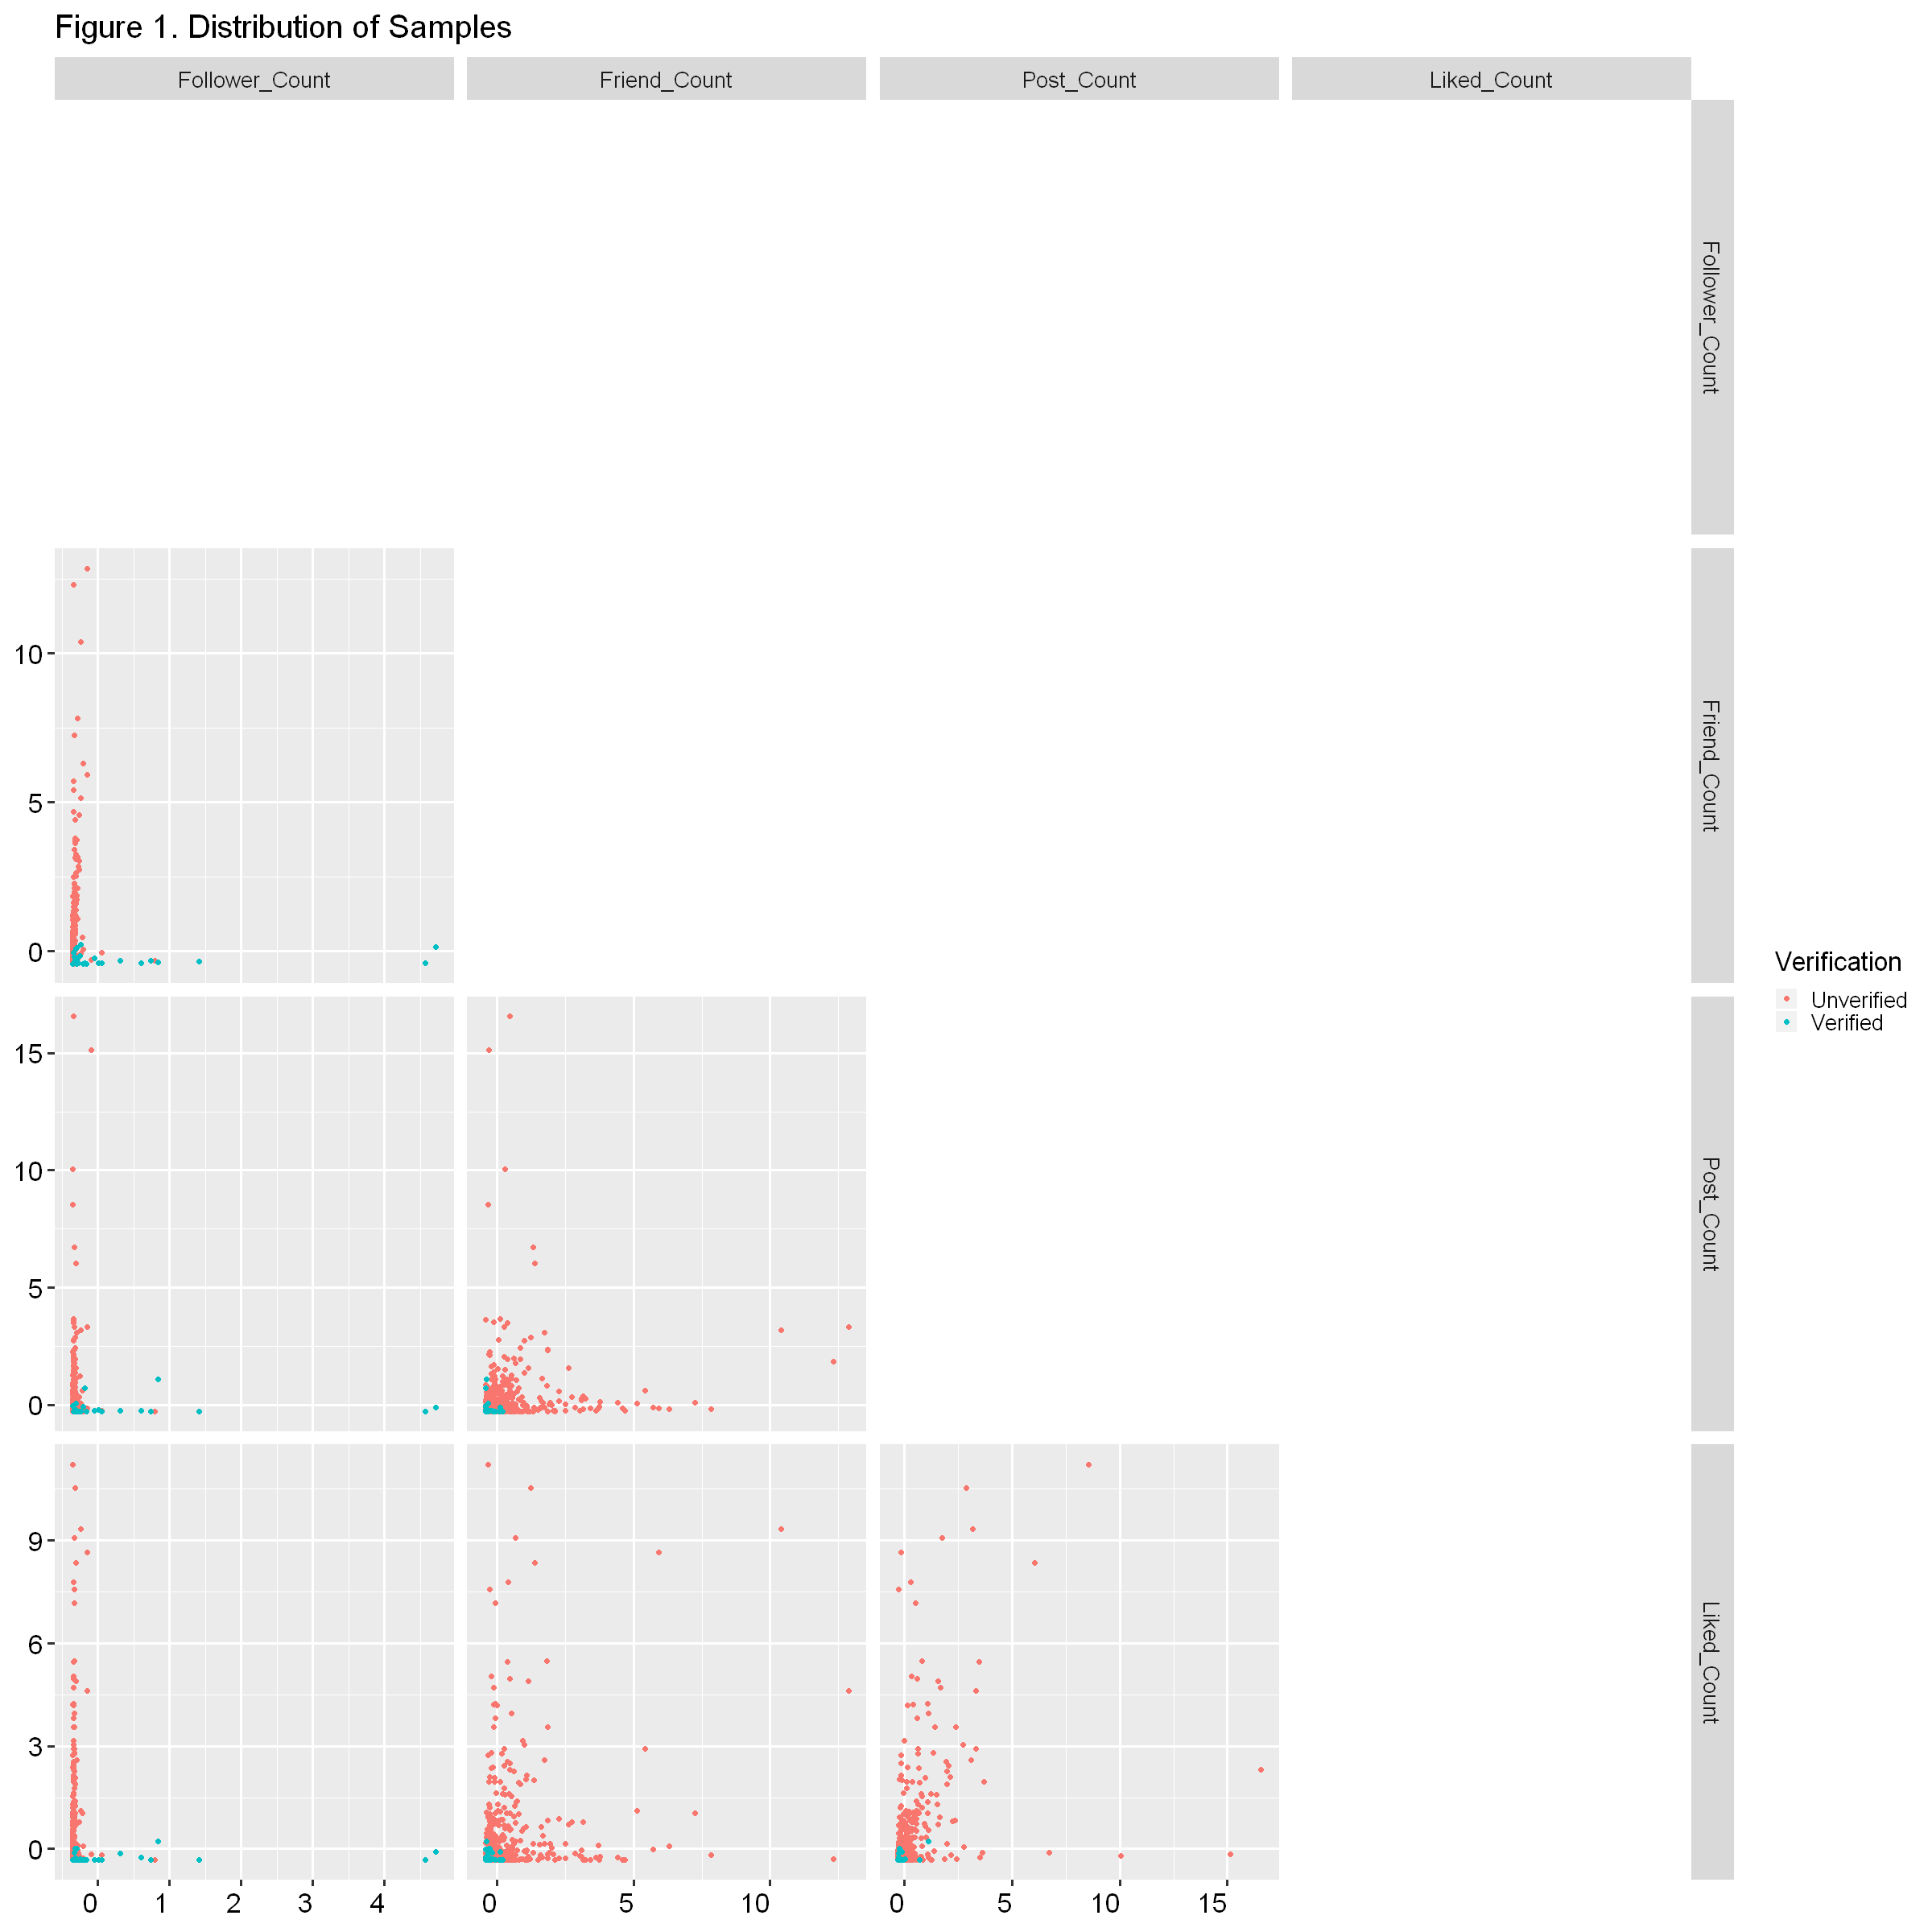

In [11]:
# In a plot of Follower_Count and Post_Count or of Friend_Count and Liked_Count,
# verified and unverified accounts seem most distinct.

library(GGally)
options(repr.plot.width = 20, repr.plot.height = 20) 

plot_pairs <- training_set %>% 
  select(Follower_Count,Friend_Count,Post_Count,Liked_Count,is_verified) %>% 
  
  ggpairs(legend=5,
          columns=1:4,
          mapping = ggplot2::aes(color = is_verified),
          upper="blank",
          diag = NULL)+

          labs(color="Verification")+

          ggtitle("Figure 1. Distribution of Samples") +

          theme(plot.title = element_text(hjust = 1),
                axis.text.x = element_text(hjust = 1, color = "black",size=20),
                axis.text.y = element_text(hjust = 1, color = "black",size=20),
                legend.position = "bottom")+
        　 
          theme_grey(base_size = 20)

plot_pairs

# 3. Method

The twitter data that was used was already in tidy format; therefore, there is very little cleaning or wrangling to do. However, the original data had 1.5 million observations and was whittled down to 1000. After cleaning, analysis was performed to determine whether a twitter account is verified (class) based on three different groupings of variables: the number of followers, posts, likes, and friends. These were the numerical variables that could be used to determine the class. To determine which group of variables would produce the most accurate results, they were grouped into follower+post count; friend+like count; and follower, post, and like count. Then the most accurate k value for each group was determined by plotting k values as multiples of 10 against the prediction accuracy for that k value. The most accurate k value was found to be 1. Using this information, the test data was used to predict whether an account was verified or not using all three variable groupings. The accuracy of each variable grouping was visualized as a bar graph of its percentage success. All three categories had a percentage success of 92-99.6%.


## 3.1 Cleaning & Wrangling 

## 3.2 Cross-validation (10 folds) and  Choosing K

### 3.2a Follower_Count and Post_Count

In [12]:
# Split data into training and test sets
X_train_a <- training_set %>% 
    select(Follower_Count, Post_Count) %>% 
    data.frame()

Y_train <- training_set %>% 
    select(is_verified) %>% 
    unlist()

X_test_a <- test_set %>% 
    select(Follower_Count, Post_Count) %>% 
    data.frame()

Y_test <- test_set %>% 
    select(is_verified) %>% 
    unlist()

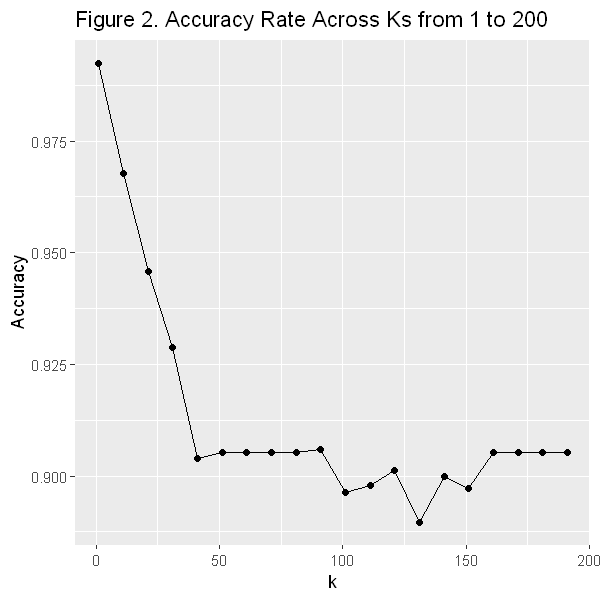

In [13]:
# Choosing K (1)
options(repr.plot.width = 5, repr.plot.height = 5) 

train_control <- trainControl(method="cv", number = 10)

k = data.frame(k = seq(from = 1, to = 200, by = 10))
knn_model_cv_10fold <- train(x = X_train_a, y = Y_train, method = "knn", tuneGrid = k, trControl = train_control)

accuracy <-knn_model_cv_10fold$results
accuracy_vs_k_lots <- ggplot(accuracy, aes(x = k, y = Accuracy)) +
  geom_point() +
  geom_line()+
  ggtitle("Figure 2. Accuracy Rate Across Ks from 1 to 200")
accuracy_vs_k_lots

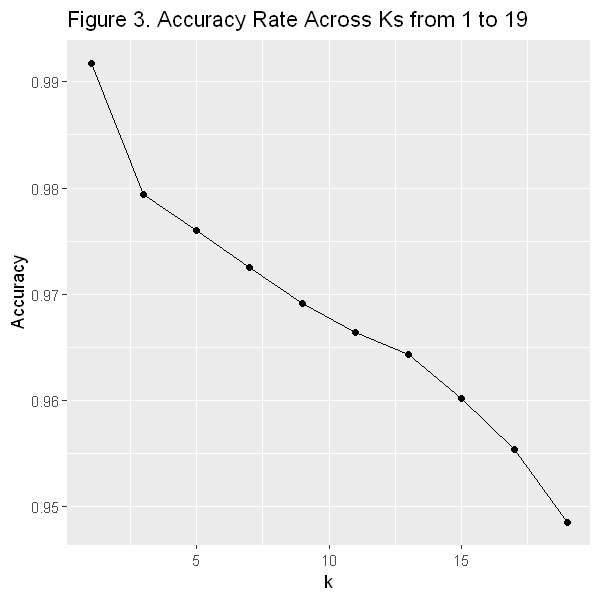

In [14]:
#choosing K(2)
train_control <- trainControl(method="cv", number = 10)
k = data.frame(k = c(1,3,5,7,9,11,13,15,17,19))

knn_model_cv_10fold <- train(x = X_train_a, y = Y_train, method = "knn", tuneGrid = k, trControl = train_control)
accuracy_2 <-knn_model_cv_10fold$results

accuracy_vs_k <- ggplot(accuracy_2, aes(x = k, y = Accuracy)) +
  geom_point() +
  geom_line()+
  ggtitle("Figure 3. Accuracy Rate Across Ks from 1 to 19")

accuracy_vs_k

### 3.2b Friend_Count and Liked_Count

In [15]:
# Split data into training and test sets
X_train_b <- training_set %>% 
    select(Friend_Count, Liked_Count) %>% 
    data.frame()

X_test_b <- test_set %>% 
    select(Friend_Count, Liked_Count) %>% 
    data.frame()

$title
[1] "Figure 4. Accuracy Rate Across Ks from 1 to 200"

attr(,"class")
[1] "labels"

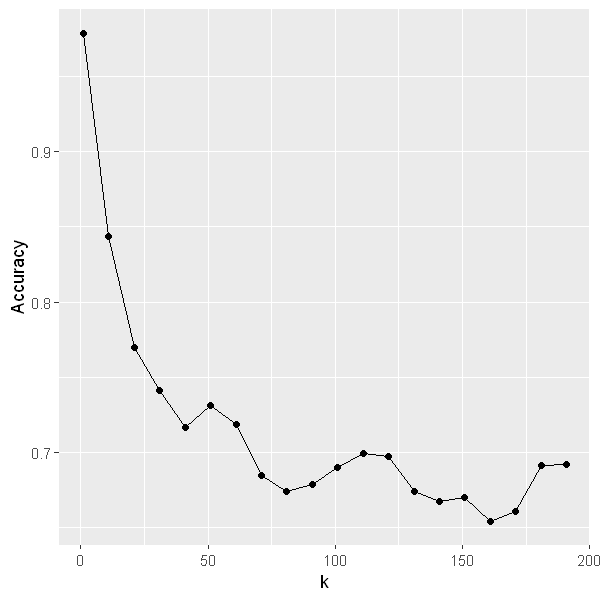

In [16]:
# Choosing K (1)
train_control <- trainControl(method="cv", number = 10)
k = data.frame(k = seq(from = 1, to = 200, by = 10))

knn_model_cv_10fold <- train(x = X_train_b, y = Y_train, method = "knn", tuneGrid = k, trControl = train_control)

accuracy <-knn_model_cv_10fold$results
accuracy_vs_k_lots <- ggplot(accuracy, aes(x = k, y = Accuracy)) +
  geom_point() +
  geom_line()
  ggtitle("Figure 4. Accuracy Rate Across Ks from 1 to 200")
accuracy_vs_k_lots

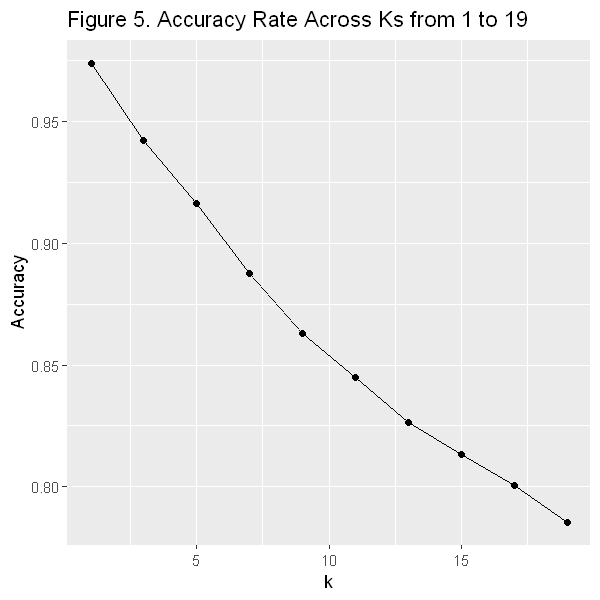

In [17]:
#choosing K(2)
train_control <- trainControl(method="cv", number = 10)
k = data.frame(k = c(1,3,5,7,9,11,13,15,17,19))

knn_model_cv_10fold <- train(x = X_train_b, y = Y_train, method = "knn", tuneGrid = k, trControl = train_control)
accuracy_2 <-knn_model_cv_10fold$results

accuracy_vs_k <- ggplot(accuracy_2, aes(x = k, y = Accuracy)) +
  geom_point() +
  geom_line()+
  ggtitle("Figure 5. Accuracy Rate Across Ks from 1 to 19")

accuracy_vs_k

### 3.2c Follower_Count, Post_Count, and Liked_Count 

In [18]:
# Split data into training and test sets
X_train_c <- training_set %>% 
    select(Follower_Count,Post_Count, Liked_Count) %>% 
    data.frame()

X_test_c <- test_set %>% 
    select(Follower_Count,Post_Count, Liked_Count)%>% 
    data.frame()

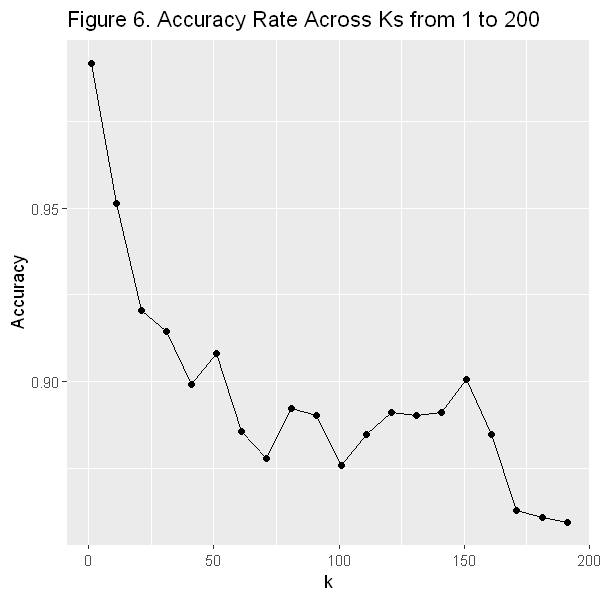

In [19]:
# Choosing K (1)
train_control <- trainControl(method="cv", number = 10)
k = data.frame(k = seq(from = 1, to = 200, by = 10))

knn_model_cv_10fold <- train(x = X_train_c, y = Y_train, method = "knn", tuneGrid = k, trControl = train_control)

accuracy <-knn_model_cv_10fold$results
accuracy_vs_k_lots <- ggplot(accuracy, aes(x = k, y = Accuracy)) +
  geom_point() +
  geom_line()+
  ggtitle("Figure 6. Accuracy Rate Across Ks from 1 to 200")
accuracy_vs_k_lots

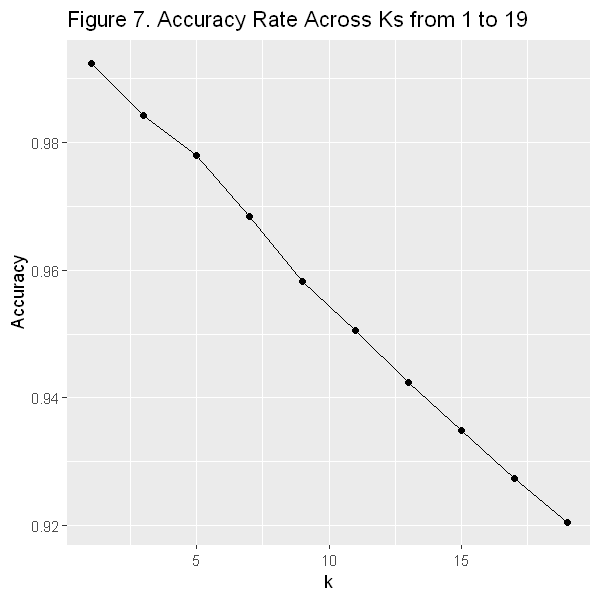

In [20]:
#choosing K(2)
train_control <- trainControl(method="cv", number = 10)
k = data.frame(k = c(1,3,5,7,9,11,13,15,17,19))

knn_model_cv_10fold <- train(x = X_train_c, y = Y_train, method = "knn", tuneGrid = k, trControl = train_control)
accuracy_2 <-knn_model_cv_10fold$results

accuracy_vs_k <- ggplot(accuracy_2, aes(x = k, y = Accuracy)) +
  geom_point() +
  geom_line()+
  ggtitle("Figure 7. Accuracy Rate Across Ks from 1 to 19")

accuracy_vs_k

## 3.3 Training Error 


In [56]:
#4.2a Follower_Count and Post_Count
error <- train(x = X_train_a, y = Y_train, method = "knn", tuneGrid = data.frame(k=1))
training_pred <- predict(object=error, X_train_a)
training_results_a <- confusionMatrix(training_pred, Y_train)
training_results_a$overall[1]

Accuracy 
       1

In [57]:
#4.2b Friend_Count and Liked_Count
error <- train(x = X_train_b, y = Y_train, method = "knn", tuneGrid = data.frame(k=1))
training_pred <- predict(object=error, X_train_b)
training_results_b <- confusionMatrix(training_pred, Y_train)
training_results_b$overall[1]

Accuracy 
0.994513

In [58]:
#4.2c Follower_Post, Post_Count, and Liked_Count
error <- train(x = X_train_c, y = Y_train, method = "knn", tuneGrid = data.frame(k=1))
training_pred <- predict(object=error, X_train_c)
training_results_c <- confusionMatrix(training_pred, Y_train)
training_results_c$overall[1]

Accuracy 
       1

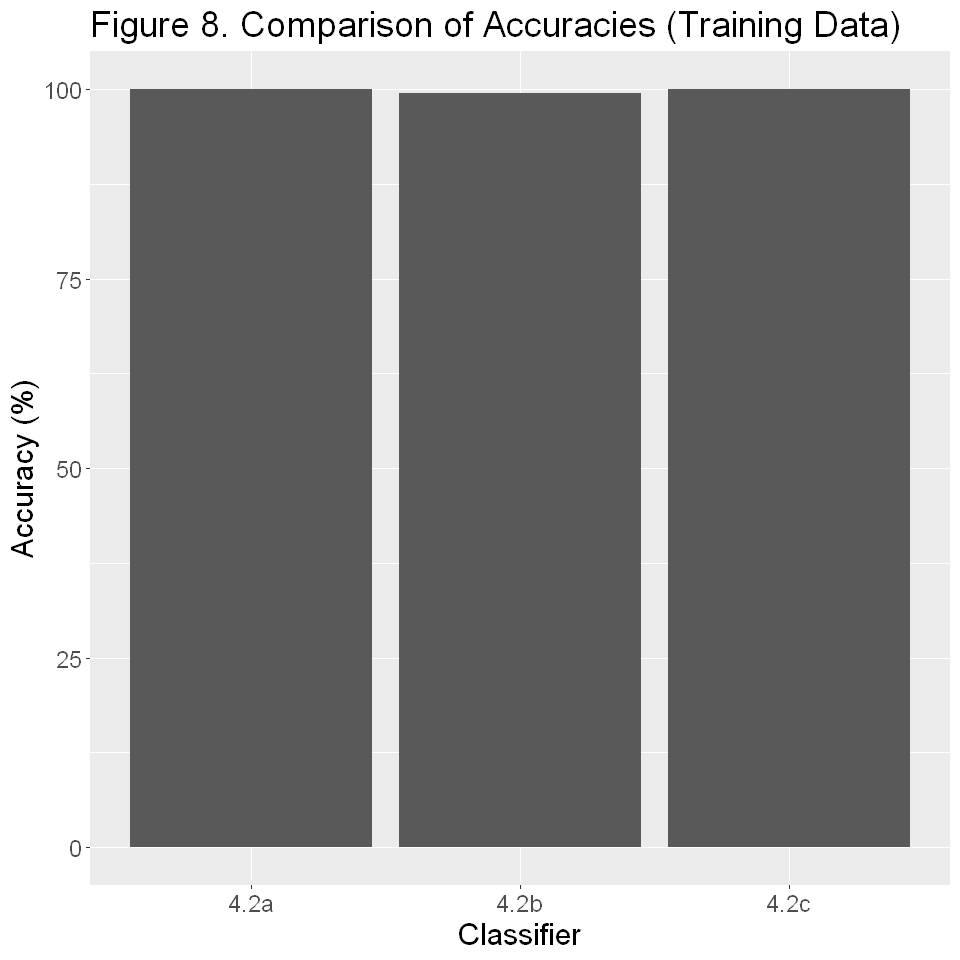

In [65]:
a <- data.frame(classifier="4.2a",accuracy=training_results_a$overall[1]) 
rownames(a) <- c()
b <- data.frame(classifier="4.2b",accuracy=training_results_b$overall[1]) 
rownames(b) <- c()
c <- data.frame(classifier="4.2c",accuracy=training_results_c$overall[1]) 
rownames(c) <- c()

rbind(a,b,c) %>% ggplot(aes(x=classifier,y=accuracy*100))+
    geom_bar(stat = "identity")+
    labs(x="Classifier",y="Accuracy (%)",cex.lab=10)+
    theme(text = element_text(size = 18))+
    ggtitle("Figure 8. Comparison of Accuracies (Training Data)")


## 3.4 Result (Test Data)

In [24]:
#4.2a Follower_Count and Post_Count
k = data.frame(k = 1)
model_knn_a <- train(x = X_train_a, y = Y_train, method = "knn", tuneGrid = k)

Y_test_predicted_a <- predict(object = model_knn_a, X_test_a)

model_quality_a <- confusionMatrix(data = Y_test_predicted_a, reference = Y_test)
model_quality_a$overall[1]

Accuracy 
0.9958848

In [25]:
#4.2b Friend_Count and Liked_Count
k = data.frame(k = 1)
model_knn_b <- train(x = X_train_b, y = Y_train, method = "knn", tuneGrid = k)

Y_test_predicted_b <- predict(object = model_knn_b, X_test_b)

model_quality_b <- confusionMatrix(data = Y_test_predicted_b, reference = Y_test)
model_quality_b$overall[1]

Accuracy 
0.9855967

In [26]:
#4.2c Follower_Post, Post_Count, and Liked_Count
k = data.frame(k = 1)
model_knn_c <- train(x = X_train_c, y = Y_train, method = "knn", tuneGrid = k)

Y_test_predicted_c <- predict(object = model_knn_c, X_test_c)

model_quality_c <- confusionMatrix(data = Y_test_predicted_c, reference = Y_test)
model_quality_c$overall[1]

Accuracy 
0.9938272

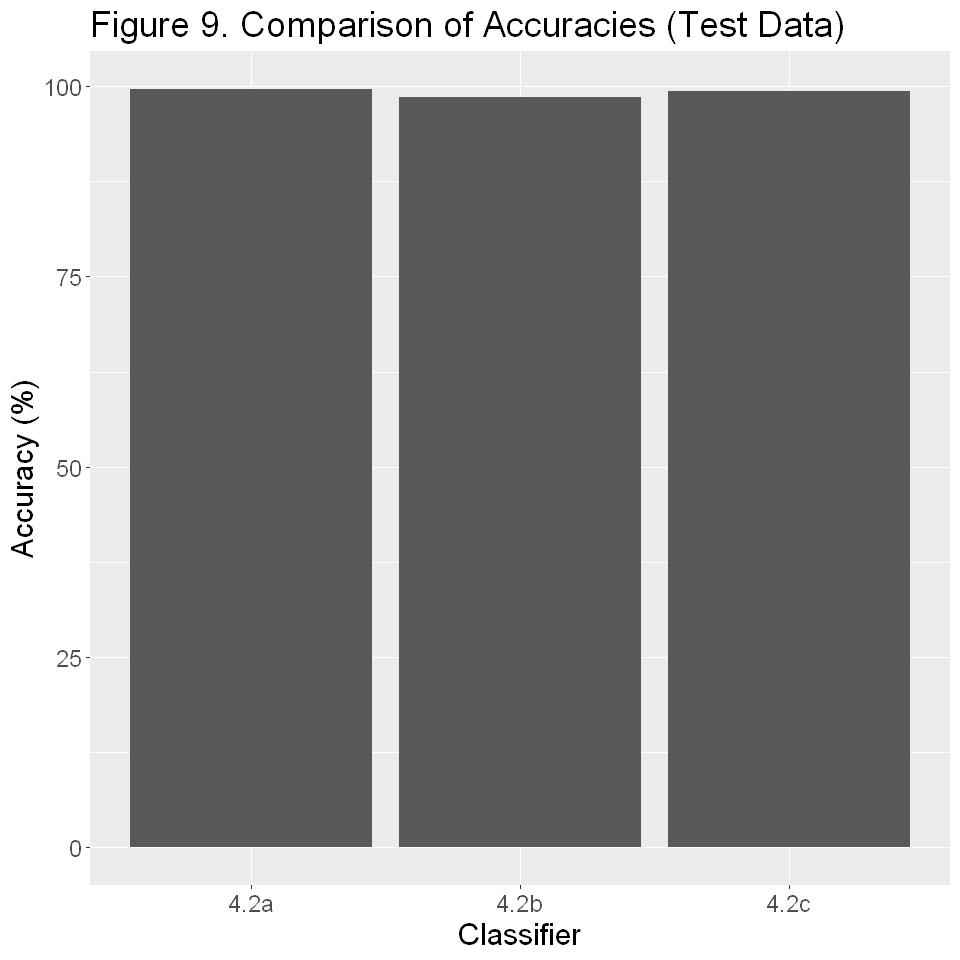

In [64]:
options(repr.plot.width = 8, repr.plot.height = 8) 
a <- data.frame(classifier="4.2a",accuracy=model_quality_a$overall[1]) 
rownames(a) <- c()
b <- data.frame(classifier="4.2b",accuracy=model_quality_b$overall[1]) 
rownames(b) <- c()
c <- data.frame(classifier="4.2c",accuracy=model_quality_c$overall[1]) 
rownames(c) <- c()


rbind(a,b,c) %>% ggplot(aes(x=classifier,y=accuracy*100))+
    geom_bar(stat = "identity")+
    labs(x="Classifier",y="Accuracy (%)",cex.lab=10)+
    theme(text = element_text(size = 18))+
    ggtitle("Figure 9. Comparison of Accuracies (Test Data)")
    

#  4. Discussion

By analyzing 1000 Twitter accounts chosen at random, this project tends to discover a class association that states accounts with higher followers, posts, and likes will probably be verified.
    Predicting whether an account will be verified and then determining which factor is most predominant, contributes to ascertaining what kind of social benchmarks must be reached for the common Twitter account to become verified.
    However, some questions arising from this analysis. Firstly, Twitter Verified is a status given by Twitter directly, does follower_count matter as much as legitimate followers? In essence, does quantity beat quality when Twitter goes through the account verification process? Furthermore, are there any instances of outliers, such as some public figures that meet all of our benchmarks but are not Twitter Verified? What are the causes of these outlier status? These questions are what would not be solved and will be explored in the future study.



#  5. References

- AAA.(1999). Title. Retirieved from http://XXX.